In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr
from numpy.linalg import inv

In [ ]:
%%capture
%run Vector.ipynb
%run Covariance.ipynb
%run ODESolver.ipynb
%run ExtendedKalman.ipynb

# Unscented Transform

$$
\def\M#1{{[\mathbf{#1}]}}
\def\MM#1#2{{[\mathbf{#1}{#2}]}}
\def\E{\operatorname{E}}
\def\cov{\operatorname{cov}}
\def\T{^\mathsf{T}}
$$
Several parts of the Kalman filter require a matrix in one frame to be transformed into that of another frame. For example, the time update of the linear Kalman filter uses the state transition matrix to transform the state covariance matrix forward in time:

$$\MM{P}{^-}=\M{A}\MM{P}{_{i-1}}\M{A}\T+\M{Q}$$

Also, calculating the Kalman gain requires transforming the state covariance matrix to measurement space:

$$\M{\Gamma}=\M{H}\MM{P}{^-}\M{H}\T+\M{R}$$

In a problem with nonlinear physics, there is no such matrix $\M{A}$, and in a problem with nonlinear observations, there is no such matrix $\M{H}$. The extended Kalman filter calculates approximations to these matrices by using the Jacobian matrix of the dynamics and/or observation functions. This requires the Jacobian matrix to be available, either from explicitly derived formulas or numerical finite difference approximations.

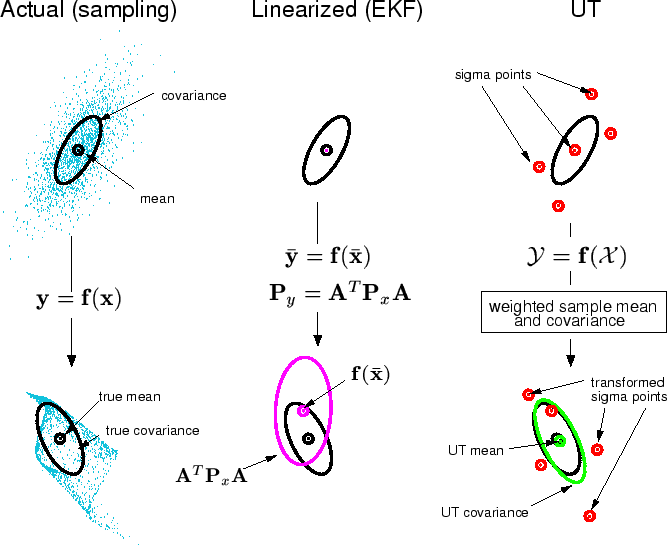
In this example, the top left shows the normally-distributed input with its mean and covariance, while the bottom-left shows that point cloud washed through a quite nonlinear transformation. Using methods shown before, it is easy to measure the covariance of the point cloud after the transformation. This covariance is still valid, even though the distribution is no longer Gaussian. This is the correct way to do the transformation, but is enormously expensive. Look at all the points you have to track! In order to actually implement this Monte Carlo method, you have to generate a large (ideally infinite, but who has time for that?) number of samples with the appropriate distribution around the estimated state, then propagate each sample through the nonlinear transformation. It ends up being an infinity-squared problem, where you want an infinite number of points, and want to walk each of them through a numerical integrator with an infinite number of steps.

In the middle column, we linearize the transformation about the mean to get $\M A$, then run the original covariance through it. The purple ellipse shows this transformation, and shows that it is not particularly close to the actual covariance.

In the right column, we do a hybrid. Instead of using a potentially infinite number of points and transforming all of them, we use a very-carefully selected *finite* number of points, on the order of a few for each element of the state vector. We run each of those through the nonlinear transformation, then use a weighted average and weighted sample covariance finder to get the mean and covariance estimates. The diagram indicates that this is much closer to the actual results. This is provable, *if* we carefully choose our samples (called sigma-points) and *if* we use the right weighting when calculating the mean and covariance. This is the unscented transform -- using a finite carefully selected set of sigma points to approximate the result we would get with an infinite set of Monte Carlo points.

Although we are looking at the estimate covariance here, we can do the same thing with the nonlinear transform from state space to measurement space to get the transformed measurement covariance.

Note that in neither case do we end up with an explicit $\M A$ or $\M H$. The filter form will have to be adapted to deal with this. In pseudocode the appropriate equations are replaced with:

$$\begin{eqnarray*}
(\vec{x}^-,\MM{P}{^-_i})&=&UT(f,\vec{x}_{i-1},\MM{P}{_{i-1}}) &+ &\M Q \\
\M \Gamma&=&UT(g,\MM{P}{^-_i})&+&\M R
\end{eqnarray*}$$

where $UT(h,\M M)$ is the unscented transform of $\M M$ using the nonlinear transformation function $h$. Specifically, $\vec{x}^-_i=f(\vec{x}_{i-1})$ is the state transformation function, and $\vec{y}=g(\vec{x})$ is the measurement function. Function $f$ is often calculated by numerical integration of $\dot{\vec{x}}=F(\vec{x})$, while $g$ is often calculated directly but with components involving trigonometry, square roots, or other nonlinear functions.

Performing the unscented transform then requires the following three steps:

1. Calcuate the sigma points and weights
2. Transform each sigma point
3. Reconstruct the mean and covariance from the transformed sigma points

Each of these steps will be discussed in turn.

## Constructing the sigma points
Given a mean value $\vec{x}$ in an $n$-dimensional space, and an $n \times n$ covariance matrix about that mean $\M{P}$, we do the following to construct the sigma points. Notice that this is a recipe with no justification, for that see the papers. The exact form of the following recipe is drawn from UKF1.pdf .

The points are constructed in two series:

$$\begin{eqnarray*}
\vec{x}_j&=&\vec{x}+\left(\sqrt{n\M{P}}\right)_j \\
W_j&=&\frac{1}{2n} \\
\vec{x}_{j+n}&=&\vec{x}-\left(\sqrt{n\M{P}}\right)_j \\
W_{j+n}&=&\frac{1}{2n}
\end{eqnarray*}$$

where $\left(\sqrt{\M{M}}\right)_j$ is row or column $j$ (0-based) of the matrix square root of $\M{M}$. We run this for each value of $j$ from 0 to $n-1$. Use a Cholesky decomposition to find this square root. If your decomposition algorithm produces $\M{A}=\sqrt{\M{M}}$ such that $\M{M}=\M{A}\T\M{A}$, then use ''rows'' of $\M{A}$. This is referred to as the ''upper'' triangular decomposition, because $\M{A}$ will be upper triangular. Otherwise if $\M{M}=\M{A}\M{A}\T$ then use ''columns'' of $\M{A}$. This is referred to as the ''lower'' triangular decomposition, for similar reasons. The numpy function `numpy.linalg.cholesky()` returns the lower form, so we pull columns out of it.

Other sets of sigma points can be constructed, some of which may match the uncertainty distribution in higher-order moments than just mean and covariance. The requirement is that the sum of the weights is 1

$$\sum_{j}W_j=1$$

Each individual weight may be positive or negative. For instance, if the original distribution is Gaussian, you can add a point at the mean, adjust the weights, and match the fourth order moment of the Gaussian distribution (Third order, skewness, is zero for a Gaussian). In this case we have:

$$\begin{eqnarray*}
\vec{x}_0&=&\vec{x} \\
W_0&=&1/3 \\
\vec{x}_{j+1}&=&\vec{x}+\left(\sqrt{\frac{n}{1-W_0}\M{P}}\right)_j \\
W_{j+1}&=&\frac{1-W_0}{2n} \\
\vec{x}_{j+n+1}&=&\vec{x}-\left(\sqrt{\frac{n}{1-W_0}\M{P}}\right)_j \\
W_{j+n+1}&=&\frac{1-W_0}{2n} \\
\end{eqnarray*}$$

In general, $W_0=1/3$ is recommended for the Gaussian distribution. Higher values tend to move the points further from the mean, while lower values move the points closer. $W_0=1$ is a particularly bad value. It weights the central point 100%, and forces the other values to divide by zero and weight that result 0%.


In [ ]:
def sigma(x,P,W0=1/3):
    """
    Construct a set of sigma points and weights
    :param x: Initial vector
    :param P: Covariance of vector
    :return: A tuple:
       sigx - a numpy 2D array holding a bunch of column vectors, one for each sigma point
       W   - a numpy 1D array holding the weights -- W[j] is the weight for sigma[:,j]
    """
    n=x.size
    sig=np.zeros((n,2*n+1))
    W=np.zeros(2*n+1)+(1-W0)/(2*n)
    sig[:,0]=x.ravel()
    W[0]=W0
    snP=cholesky((n/(1-W0))*P)
    #print(snP)
    #print(snP@snP.T)
    #print(n/(1-W0))
    for j in range(n):
        sig[:,j  +1]=(x+snP[:,j].reshape(-1,1)).ravel()
        sig[:,j+n+1]=(x-snP[:,j].reshape(-1,1)).ravel()
    return (sig,W)

x0=np.array([[-100],[-200]])
P=np.array([[3,3],[3,4]])
(sig,W)=sigma(x0,P)
print(sig)
print(W)
nr.seed(3217)
x=pnoise(1000,P,x0)
e1=pell(1,P,x0)
e2=pell(2,P,x0)
e3=pell(3,P,x0)
plt.figure("Sigma point demo")
plt.plot(x [0,:],x [1,:],'k.',label='random point cloud')
plt.plot(e1[0,:],e1[1,:],'r-',label='1-sigma ellipse')
plt.plot(e2[0,:],e2[1,:],'g-',label='2-sigma ellipse')
plt.plot(e3[0,:],e3[1,:],'b-',label='3-sigma ellipse')
plt.plot(sig[0,:],sig[1,:],'y*',label='sigma points')
plt.axis('equal')
plt.legend()
plt.show()

## Transforming the Sigma Points
In general, you can use any old function which takes a vector and gives back a vector, either of the same number or different number of dimensions. However for the normal case used, the dynamics is determined by a first order vector ordinary differential equation. We end up with:

$$\begin{eqnarray*}
\dot{\vec{x}}&=&f(\vec{x},t)\\
\vec{x}(t)&=&\vec{x}(t_0)+\int_{t_0}^t f(\vec{x}(\tau),\tau) d\tau
\end{eqnarray*}$$

The latter is performed by any ODE solver, using the original point value as the initial condition. It's pretty common to use a quick, not-so-accurate solver, as the hope is that any errors caused by the ODE solver are drowned out by the errors naturally present in the covariance and measurement uncertainty. If we do it as a first-order one-step Euler solver, we end up with:

$$\vec{x}(t)=\vec{x}(t_0)+(t-t_0)f(\vec{x}(t_0),t_0)$$

The usual form for the observation function is just an explicit nonlinear function which calculates the measurement vector given the state vector. Usually no integration is needed.

We will say that the transformed value of each input point $\vec{x}_j$ is $\vec{x}_j'$, so we have for general nonlinear function $\operatorname h(\vec{x})$

$$\vec{x}_j'=\operatorname h(\vec{x}_j)$$

## Reconstructing the Distribution
Again, this is presented without justification, as a pure recipe. However, when you perform these operations on the untransformed sigma points, you *do* get back the original mean and covariance.

The transformed mean $\vec{x}'$ is then

$$\vec{x}'=\sum_j W_j \vec{x}'_j$$

For the preferred extra mean point above, the index $j$ runs from $0$ to $2n$ inclusive.

The transformed covariance is then

$$\MM{P}{'}=\sum_j W_j \left\{\vec{x}'_j-\vec{x}'\right\}\left\{\vec{x}'_j-\vec{x}'\right\}\T$$

Note that in the case of transforming from state space to measurement space, the resulting mean and covariance will have size $m$ and $m \times m$ where $m$ may not equal $n$. In fact the usual case for a Kalman filter is that $m \lt n$. Even so, the sums above run $j$ over each sigma point, the number of which is determined by the number of elements in state space, not measurement space.

In [ ]:
def sigmainv(sig,W):
    x=np.sum(sig*W.reshape(1,-1),axis=1).reshape(-1,1)
    #print(x)
    nn=sig.shape[1] #Number of sigma points
    P=np.zeros((x.size,x.size))
    #print(P.shape)
    for j in range(nn):
        #print("sig[j=%d]: "%j)
        #print(sig[:,j].reshape(-1,1))
        dx=(x-sig[:,j].reshape(-1,1))
        #print("dx=")
        #print(dx)
        Pterm=W[j]*(dx@dx.T)
        #print("Pterm=")
        #print(Pterm)
        P+=Pterm
        #print("P=")
        #print(P)
    return (x,P)

(xout,Pout)=sigmainv(sig,W)
print(xout,x0)
print(Pout)
print(xout-x0)
print(np.max(np.abs(xout-x0))<1)
print(Pout-P)
print(np.max(np.abs(Pout-P ))<1e-15)
e1out=pell(1,Pout,xout)
e2out=pell(2,Pout,xout)
e3out=pell(3,Pout,xout)
plt.figure("Sigma point reconstruct")
plt.plot(x [0,:],x [1,:],'k.',label='Point cloud')
plt.plot(e1[0,:],e1[1,:],'r-',label='1-sigma curve')
plt.plot(e1out[0,:],e1out[1,:],'k--',label='1-sigma from sigma point')
plt.plot(e2[0,:],e2[1,:],'g-',label='2-sigma curve')
plt.plot(e2out[0,:],e2out[1,:],'k--',label='2-sigma from sigma point')
plt.plot(e3[0,:],e3[1,:],'b-',label='2-sigma curve')
plt.plot(e3out[0,:],e3out[1,:],'k--',label='3-sigma from sigma point')
plt.plot(sig[0,:],sig[1,:],'y*',label='Sigma points')
plt.axis('equal')
plt.legend()
plt.show()

# Example transform
We will take a look at a test mass making a close pass by a central mass. The error ellipsoid is large enough that during the passage by the center, samples in different parts of the error ellipsoid will make passes at large differences in distance and therefore will be scattered quite a lot. This is intended to activate the nonlinearity inherent in the problem.

Our physics function is the same for all propagators. We will do the physics function symbolically so that we can do automatic symbolic derivatives to feed the EKF what it needs. The Monte Carlo and Unscented propagators won't need the Jacobian, but can use the vector derivative just as well as the Extended propagator can.

Our framework supports parameters like the $\mu$ parameter and station coordinates, but we won't use them here.

In [ ]:
%%capture
%run NonlinearKalman.ipynb
    

In [ ]:
#Symbolic form of physics equations
rx,ry,vx,vy=sympy.symbols('r_x r_y v_x v_y')
#It's OK to introduce intermediate symbols, since they are still defined in terms
#of the symbols we will be using in the state vector
r=sympy.sqrt(rx**2+ry**2) 
Frx=vx
Fry=vy
Fvx=-rx/r**3
Fvy=-ry/r**3
(Fnl,Phinl)=fjac([rx,ry,vx,vy],[],[Frx,Fry,Fvx,Fvy])
mx=2
my=0
rho=sympy.sqrt((rx-mx)**2+(ry-my)**2)
theta=sympy.atan2(ry-my,-(rx-mx)) #Put the branch cut on the x-axis, so that the test orbit doesn't cross it
(gnl,Hnl)=fjac([rx,ry,vx,vy],[],[rho,theta])


The initial condition is also the same between propagators. I chose the initial condition arbitrarily, expecting it to be hyperbolic, but with a large bending angle. As it turns out, the speed I chose is hyperbolic, but only just...

In [ ]:
t0=0
t1=20
dt=0.1
ts=np.arange(t0,t1,dt) #Time series
n_t=ts.size
x0=np.array([[8],[2],[-0.5],[0]])
P0=np.diag([0.01,0.01,1e-5,1e-5])
nstep=1
vesc0=np.sqrt(2/vlength(x0[0:2,:]))
print("Vesc at initial position: ",vesc0)
print("Actual velocity at initial condition: ",vlength(x0[2:4,:]))

Since we know that this is gravity with $\mu=1$, we can use the solution to the Kepler problem to get our exact answer:

In [ ]:
%%capture
%run UniversalVariables.ipynb

In [ ]:
elorb(x0)

We will be comparing three propagators:

* The Monte Carlo propagator. This one generates a large cloud of points at random, with the desired initial mean and covariance. The larger the cloud, the better. With a large enough point cloud, we expect this one to be the best representation of "truth", but also the most computationally intensive.

In [ ]:
n_cloud=1000 #Number of elements in the point cloud
nr.seed(3217)
xm = pnoise(n_cloud, P0, x0)
el=elorb(xm)
#Now we can calculate the whole trajectory of a whole point cloud at once
xt=kepler(x0,None,np.arange(0,20,0.1))
xtm=kepler(xm,None,np.arange(0,20,0.1).reshape(-1,1,1))
print(xt.shape)
plt.figure("Nominal trajectory")
plt.plot(0,0,'k+')
print(xtm.shape)
#Plot the first 10 trajectories
for i in range(np.min((10,xtm.shape[2]))):
    plt.plot(xtm[:,0,i],xtm[:,1,i])
plt.plot(xt[0,:],xt[1,:],'b',label='Nominal')
plt.legend()
plt.axis('equal')
plt.show()
plt.figure("Eccentricity histogram")
plt.hist(el.e,100)
plt.show()

Note that the eccentricity of the point cloud includes some values less than 1, indicating that some orbits in the cloud will be elliptical.

* The Extended Kalman Filter propagator. This one propagates the mean (or current best estimate) and uses the Jacobian of the physics function to propagate the covariance. It is expected to be the least accurate propagator of the covariance, but the performance benchmark against which to compare the Unscented propagator. 

In [ ]:
xe=x0*1
Pe=P0*1

* The Unscented transform propagator. This uses a finite number of carefully chosen points, as opposed to the ideally infinite number that the Monte Carlo propagator uses. We expect it to have a propagated covariance closer to the Monte Carlo "Truth" value than the EKF propagator, and will compare its computational effort of propagating many sigma points to that of calculating and using the Jacobian matrix for the EKF.

In [ ]:
(xu, W) = sigma(x0, P0)

Now we run all of the propagators in lockstep, using the same physics function, same initial condition, same time steps, etc. 

In [ ]:
plt.figure("EKF, MCKF, and UKF")
plt.plot([0], [0], 'kx')
dt=ts[1]-ts[0]
for i, t in enumerate(ts):
    #Do all of the plotting
    if i % 20 == 0 or i+1==len(ts):
        if i+1==len(ts) or i==120:
            plt.plot(xm[0, :], xm[1, :], 'r+',label="Monte Carlo point cloud")
            plt.plot(xtm[i,0,:],xtm[i,1,:],'y+',label="Kepler point cloud")
        (xmbar, Pm) = pcalc(xm)
        (cm, sm) = pell(3, Pm[0:2,0:2], xmbar[0:2])
        plt.plot(cm, sm, 'r-',label='Monte Carlo' if i==0 else None)

        if i+1==len(ts):
            plt.plot(xe[0, :], xe[1, :], 'bo',label="EKF estimate")
        (ce, se) = pell(3, Pe[0:2,0:2], xe[0:2])
        plt.plot(ce, se, 'b-',label='Linearized' if i==0 else None)

        if i+1==len(ts):
            plt.plot(xu[0, :], xu[1, :], 'g+',label="Sigma point cloud")
        (xubar, Pu) = sigmainv(xu, W)
        (cu, su) = pell(3, Pu[0:2,0:2], xubar[0:2])
        plt.plot(cu, su, 'g-',label='Unscented' if i==0 else None)
    #Actually step the integrators
    xm = rk4(Fnl, dt, xm, [], nstep=nstep,t0=t)
    xu = rk4(Fnl, dt, xu, [], nstep=nstep,t0=t)
    (xe, Pe) = ekf_timeup(xh_im1=xe, P_im1=Pe, t=t, dt=dt, F=Fnl, Phi=Phinl, Fpar=[],nstep=nstep)
plt.axis('equal')
plt.legend()
plt.show()

# Measurement Update
We have seen on the Extended Kalman Filter page how we end up with a linearized measurement matrix $\M H$, calculated as the Jacobian of the measurement equations with the state vector components. The problem with the Unscented filter then is how do we transform to and from measurement space without the linearized matrix?

In what follows, vector $\hat{\vec{z}}$ is the predicted measurement, and is not necessarily a unit-vector. Vector $\vec{z}$ is the actual measurement at the given time $t$. Vectors $\vec{x}_j$ are the sigma points, and $\vec{z}_j$ are the predicted measurements from the sigma points (note the lack of hats or superscript minus on either, since sigma points are exact and not themselves estimates). Vector $\vec{y}=\vec{z}-\hat{\vec{z}}$ is the estimate, residual, and if we need it, $\vec{y}_j=\vec{z}-\vec{z}_j$ is the residual for each sigma point.


 1. Calculate the predicted measurement for each sigma point $$\vec{z}_j=\operatorname g(\vec{x}_j,t)$$
 2. Calculate the mean and covariance of the predicted measurement $$\begin{align}\hat{\vec{z}}=&\sum_{j=0}^{2n}W_j \hat{\vec{z}}_j \\
\M{\Gamma}=&\M{R}+\sum_{j=0}^{2n}W_j \left\{\hat{\vec{z}}-\hat{\vec{z}}_j\right\}\left\{\hat{\vec{z}}-\hat{\vec{z}}_j\right\}\T\end{align}$$ The second term (the big summation term) has the same purpose as the corresponding term in the linear Kalman equation: $$\M \Gamma=\M R+\M H \MM{P}{^-_i}\M H\T$$ In that equation, the indicated term is the translation of the state estimate covariance into measurement space. Here we calculate this covariance directly from the transformed sigma points.
 3. Calculate the measurement residual $$\vec{y}=\vec{z}-\hat{\vec{z}}$$
 4. Calculate the cross-covariance between the state and the residual $$\M{S}=\sum_{j=0}^{2n}W_j \left\{\vec{x}^--\vec{x}^-_j\right\}\left\{\hat{z}-\hat{z}_j\right\}\T$$ The corresponding linear Kalman equation is: $$\M S=\MM{P}{^-_i}\M H\T$$ We still haven't explained why this cross-covariance is a term of the Kalman gain matrix, but at least it is a little more clear what it is -- it's the cross-covariance between the state sigma points and the measurement sigma points.
 5. Calculate the Kalman gain, exactly like the linear filter: $$\M{K}=\M{S}\M{\Gamma}^{-1}$$
 6. Update the estimate, exactly like the linear filter: $$\vec{x}^+=\vec{x}^-+\M{K}\vec{y}$$
 7. Update the estimate covariance. We don't have $\M H$, so we can't do this exactly like the linear filter: $$\M{P}{^+}=\MM{P}{^-}-\M{K}\M{\Gamma}\M{K}\T$$ 
 

When we compare this last formula with the linear filter, we see this: $$\M{P}=(\M{1}-\M{K}\M{H})\MM{P}{^-}$$ 
 
It's obvious why we can't use the linear form, since we don't have $\M H$. However, can we prove that these two lines are equivalent, and that we can calculate this with what we have?

$$\begin{eqnarray*}
\M{P}&=&\MM{P}{^-}-\M{K}\M{\Gamma}\M{K}\T & \mbox{Unscented form} \\
  &=&\MM{P}{^-}-\M{S}\M{\Gamma}^{-1}\M{\Gamma}\M{K}\T & \mbox{Sub in definition of }\M{K}=\M{S}\M{\Gamma}^{-1}\mbox{ (same in both filters) in first spot} \\
  &=&\MM{P}{^-}-\M{S}\M{K}\T & \mbox{Cancel out multiplication of matrix with its own inverse} \\
  &=&\MM{P}{^-}-\MM{P}{^-}\M{H}\T\M{K}\T & \mbox{Sub in definition of }\M{S}=\MM{P}{^-}\M H\T\mbox{ from linear filter} \\
  &=&\MM{P}{^-}(\M{1}-\M{H}\T\M{K}\T) & \mbox{Factor out }\MM{P}{^-} \\
\M{P}\T&=&(\M{1}-\M{H}\T\M{K}\T)\T\M{P^-}\T & \mbox{Since }\M{P}\mbox{ is symmetric, }\M{P}=\M{P}\T\mbox{ and we can do this. On right side, }(\M{A}\M{B})\T=\M{B}\T\M{A}\T \\
 &=&(\M{1}\T-(\M{H}\T\M{K}\T)\T)\M{P^-}\T & \mbox{On right side, }(\M{A}+\M{B})\T=\M{A}\T+\M{B}\T \\
\M{P}&=&(\M{1}-(\M{H}\T\M{K}\T)\T)\M{P^-} & \mbox{Identity matrix is symmetric, }\M{1}=\M{1}\T\mbox{, as are }\M{P}\mbox{ and }\M{P^-} \\
     &=&(\M{1}-\M{K}\M{H})\M{P^-} & \M{A}\T\M{B}\T=\M{B}\M{A}\mbox{ which gets us to the linear form}
\end{eqnarray*}$$

So yes, we can reconcile that last line. Both calculate the same thing. The UKF form can even be used in the KF or EKF if it is convenient.

In [ ]:
def ukf_measup(sig, W, z, g,gpar, Q, R):
    """
    :param sig   : Time-updated sigma points (at current time but before taking into account current measurement)
    :param W     : Weights of sigma points
    :param z     : current measurement vector
    :param g     : Measurement function
    :param gpar  : Extra parameters to pass to measurement function
    :param Q     : Process noise covariance matrix, square n x n where n is number of elements of state vector
    :param R     : Measurement noise covariance matrix, square m x m where m is number of elements of measurement vector
    :return      : A tuple:
        xh_i - New estimated state vector, with measurement taken into account
        P_i  - New estimate covariance matrix under same conditions
    """
    def _inv(x):
        """
        Matrix inverse which also handles scalars properly
        :param x:
        :return:
        """
        try:
            from scipy.linalg import inv
            return inv(x)
        except ValueError:
            return np.array([[1.0/x]])
    # 1. Calculate the predicted measurement for each sigma point 
    z_j=g(sig,gpar)
    # 2. Calculate the mean and covariance of the predicted measurement 
    (xhat_m,P_m) =sigmainv(sig,W)
    P_m+=Q
    (zhat,Gamma)=sigmainv(z_j,W)
    Gamma+=R
    # 3. Calculate the measurement residual
    y=z-zhat
    # 4. Calculate the cross-covariance between the state and the residual 
    dx=(xhat_m-sig[:,0].reshape(-1,1))
    dz=(zhat-z_j[:,0].reshape(-1,1))
    dxdz=dx @ dz.T
    S=W[0]*dxdz
    for j in range(1,sig.shape[1]):
        S+=W[j]*(xhat_m-sig[:,j].reshape(-1,1))@((zhat-z_j[:,j].reshape(-1,1)).T)
    # 5. Calculate the Kalman gain, exactly like the linear filter
    K=S @ _inv(Gamma)
    # 6. Update the estimate, exactly like the linear filter
    xhat=xhat_m+K@y
    # 7. Update the estimate covariance. We don't have $\M H$, so we can't do this exactly like the linear filter: 
    #   $$\M{P}{^+}=\MM{P}{^-}-\M{K}\M{\Gamma}\M{K}^T$$ 
    P=P_m-K @ Gamma @ K.T
    return (xhat,P) 

Then we make a driver just like before:

In [ ]:
def ukf_step(xh_im1, P_im1, z, dt, F, Fpar, g, gpar, Q, R, odesolve=rk4, nstep=10,t=None):
    """
    Call both the UKF time update and measurement update functions to process one measurement.
    :param xh_im1: Previous estimate of the state vector
    :param P_im1 : Previous estimate covariance
    :param z     : current measurement vector
    :param dt    : time between last and current measurement
    :param F     : Physics function
    :param Fpar  : Extra parameters to pass to physics function
    :param g     : Measurement function
    :param gpar  : Extra parameters to pass to measurement function
    :param Q     : Process noise covariance matrix, square n x n where n is number of elements of state vector
    :param R     : Measurement noise covariance matrix, square m x m where m is number of elements of measurement vector
    :param odesolve: ODE solver to use, passed along to time update
    :param nstep : Number of substeps to use in the step, passed along to time update
    :param t     : Time of current measurement
    :return      : A tuple:
        xh - New estimated state vector
        P  - New estimate covariance matrix
    """
    #Calculate the sigma points
    (sig,W)=sigma(xh_im1,P_im1)
    #Do the time update of the sigma points - we don't have an explicit updated covariance, ukf_measup does that.
    sig = odesolve(F, dt, sig, Fpar, nstep=nstep)
    #Do the measurement update
    return ukf_measup(sig, W, z, g, gpar, Q, R)


While you can do the same component-wise breakdown of the measurement, it doesn't help quite as much, because you need new sigma points in between each component. Besides, doing the unscented Kalman filter requires being able to do the Cholesky decomposition, an operation of similar complexity to the matrix inverse.

If you want to filter a bunch of measurements all at once, you can use this interface (similar to ``ekf_loop()``):

In [ ]:
def ukf_loop(xh_0, P_0, z, t, F, Fpar, g, gpar, Q, R):
    """
    Drive the Unscented Kalman filter over a series of measurements. This has fewer parameters than 
    ekf_loop(), but where parameters match names, they have exactly the same purpose.

    :param xh_0: Initial guess of the state vector
    :param P_0:  Initial guess of the estimate covariance
    :param z:    Stack of measurement vectors
    :param t:    array of times, same length as number of measurements
    :param F:    Physics function
    :param Fpar: Extra Parameters to physics function 
    :param g:    Measurement function
    :param gpar: Extra parameters to measurement function
    :param Q:    Process noise covariance matrix, square n x n where n is number of elements of state vector
    :param R:    Measurement noise covariance matrix, square m x m where m is number of elements of measurement vector
    :return: A tuple
      xh - list of estimated states
      P - list of estimate covariance matrices
    """
    n = t.size  # Number of observations
    xh = np.zeros((xh_0.size, n))  # History of all estimates (starts as initial estimate)
    xh[:, 0] = xh_0.ravel();
    P = np.zeros((n,xh_0.size, xh_0.size))  # History of all estimate covariances
    P[0, :, :] = P_0;
    for i in range(1, n):
        [xh_i, P_i] = ukf_step(xh_im1=xh[:,i-1].reshape(-1,1),
                               P_im1=P[i-1,:,:],
                               z=z[:,i].reshape(-1,1),
                               dt=t[i]-t[i-1],
                               F=F,Fpar=Fpar, g=g, gpar=gpar,
                               Q=Q, R=R, t=t[i])
        # Record the current estimates
        xh[:, i] = xh_i.ravel();
        P[i,:, :] = P_i;
    return (xh, P)

# Comparison of EKF, and UKF
Above, we had the MC propagator included. It doesn't make a lot of sense to include the MC filter, because I haven't developed it yet. I don't think that it is as simple as taking the UKF code but feeding it with 1000 randomly-selected points vs our finite sigma-point choices.

First we need a true state and some true observations. We will suck these straight from the EKF orbital driver:

In [ ]:
def trueState(t,xt0):
    """
    Calculate the true trajectory, given the true initial condition and the physics function F
    """
    return kepler(xt0,None,t)

xt=trueState(t=ts,xt0=x0)

plt.figure("True trajectory")
plt.plot(xt[0,:],xt[1,:],label='true trajectory')
plt.plot(0,0,'k+',label='center')
plt.plot(mx,my,'r+',label='station')
plt.legend()
plt.axis('equal')
plt.show()

In [ ]:
def trueObs(xt,g,R=None,seed=3217):
    #Size the problem
    s=xt.shape
    n=s[0]
    xt0=xt[:,0].reshape(-1,1)
    z=np.zeros((g(xt0,None,None).size,s[1]))
    #Clean observations
    for i in range(s[1]):
        z[:,i]=g(xt[:,i].reshape(n,1),None,None).ravel()
  
    #We want random noise, but the *same* random noise each time we run
    if R is not None:
        if seed is not None:
            nr.randn(seed)
        pn=pnoise(s[1],R) #Measurement noise
        z=z+pn            #Noisy Observations
    return z

m=[10,0]
zt=trueObs(xt,gnl)
R=np.diag([0.1**2,0.01**2])
zn=trueObs(xt,gnl,R)
plt.figure("Range Observations")
plt.plot(ts,zt[0,:],'-')
plt.plot(ts,zn[0,:],'.')
plt.figure("Azimuth Observations")
plt.plot(ts,zt[1,:],'-')
plt.plot(ts,zn[1,:],'.')
plt.show()

In [ ]:
def compare_filters(ts,xt0,xh_0,P_0,Q,R,tag=""):
    # Simulated actual trajectory. Unperturbed orbit around B612 at slightly
    # higher than circlular velocity.

    xt = trueState(ts, xt0)

    zt = trueObs(xt, gnl)
    print(R)
    z = trueObs(xt, gnl, R)
    #z=zt #Give it perfect measurements, so there should be zero residual

    [xh_ekf, P_ekf] = ekf_loop(xh_0=xh_0,  # Initial state vector guess, slightly wrong
                       P_0=P_0,  # Initial state vector uncertainty, 1m in position and 1m/s in velocity
                       z=z, t=ts, F=Fnl, Phi=Phinl, Fpar=None, g=gnl, H=Hnl,gpar=None,Q=Q,R=R)
    [xh_ukf, P_ukf] = ukf_loop(xh_0=xh_0,  # Initial state vector guess, slightly wrong
                       P_0=P_0,  # Initial state vector uncertainty, 1m in position and 1m/s in velocity
                       z=z, t=ts, F=Fnl,            Fpar=None, g=gnl,       gpar=None,Q=Q,R=R)
    print(xh_ekf.shape)
    print(xh_ukf.shape)
    # Plot some interesting results
    plt.figure("Nonlinear trajectory"+tag)
    plt.plot(xt[0, :], xt[1, :], 'r+-',label='True position')
    plt.plot(xh_ekf[0, :], xh_ekf[1, :], 'b+',label='EKF Estimated position')
    plt.plot(xh_ukf[0, :], xh_ukf[1, :], 'g+',label='UKF Estimated position')
    for i in range(0,ts.size):
        (ce, se) = pell(3, P_ekf[i,0:2,0:2], xh_ekf[0:2,i].reshape(-1,1))
        plt.plot(ce, se, 'b-',label='Linearized covariance' if i==0 else None)

        (cu, su) = pell(3, P_ukf[i,0:2,0:2], xh_ukf[0:2,i].reshape(-1,1))
        plt.plot(cu, su, 'g-',label='Unscented' if i==0 else None)

    plt.legend()
    plt.axis('equal')

    # measurement residual plot
    zh_ekf = trueObs(xh_ekf, gnl)
    zh_ukf = trueObs(xh_ukf, gnl)
    plt.figure("Nonlinear range measurements"+tag)
    plt.plot(ts, zt[0,:], 'r-',label='Actual radar distance')
    plt.plot(ts, zh_ekf[0,:], 'b+',label='EKF Radar distance from estimate');
    plt.plot(ts, zh_ukf[0,:], 'g+',label='UKF Radar distance from estimate');
    plt.legend()

    plt.figure("Nonlinear range residuals"+tag)
    plt.plot(ts, zt[0,:]-zh_ekf[0,:],'+', label='EKF residuals')
    plt.plot(ts, zt[0,:]-zh_ukf[0,:],'+', label='UKF residuals')
    plt.plot(ts, zt[0,:]-z[0,:],'+', label='measurement noise')
    plt.plot(ts, ts*0, 'k-',label='residual=0');
    plt.legend()

    plt.figure("Nonlinear azimuth measurements"+tag)
    plt.plot(ts, zt[1,:], 'r-',label='Actual radar distance')
    plt.plot(ts, zh_ekf[1,:], 'b+',label='EKF Radar distance from estimate');
    plt.plot(ts, zh_ukf[1,:], 'g+',label='UKF Radar distance from estimate');
    plt.legend()

    plt.figure("Nonlinear azimuth residuals"+tag)
    plt.plot(ts, zt[1,:]-zh_ekf[1,:],'+', label='EKF residuals')
    plt.plot(ts, zt[1,:]-zh_ukf[1,:],'+', label='UKF residuals')
    plt.plot(ts, zt[1,:]-z[1,:],'+', label='measurement noise')
    plt.plot(ts, ts*0, 'k-',label='residual=0');
    plt.legend()
    plt.show()


In [ ]:
Q = np.diag([0.0, 0.0, 0.0, 0.0])  # Non-physical process noise covariance
R = np.diag([0.1 ** 2,0.01**2])  # Measurement noise covariance
xh0=x0+np.array([[0.1],[0.1],[0.1],[0.1]])
compare_filters(ts,xt0=x0,xh_0=xh0,P_0=P0,Q=Q,R=R)